## Setup and get data

In [1]:
COMPETITION_NAME = 'digit-recognizer' # replace me

# Kaggle competition bootstrapping
!pip install -qq fastai
!pip install -qq kaggle

from fastai.imports import *
np.set_printoptions(linewidth=130)

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# get competition data
if iskaggle:
    path = Path('../input/'+COMPETITION_NAME)
else:
    DOWNLOADS = Path('downloads')
    import zipfile,kaggle
    path = DOWNLOADS / COMPETITION_NAME
    if not path.is_dir():
        kaggle.api.competition_download_cli(COMPETITION_NAME, path=DOWNLOADS)
        zipfile.ZipFile(f'{path}.zip').extractall(path)
print('done')

done


In [2]:
!ls {path}

sample_submission.csv  test  test.csv  train  train.csv


## Data preprocessing
Moving csv format to images in folders

In [3]:
df = pd.read_csv(path/'train.csv')
df.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

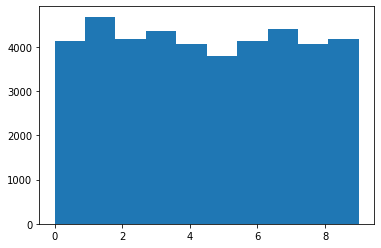

In [4]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(df.label)
plt.show()

In [5]:
test_df = pd.read_csv(path/"test.csv")
len(test_df)

28000

In [6]:
#create folders 
TRAIN_IMGS = path / 'train'
TEST_IMGS = path / 'test'
if not TRAIN_IMGS.exists():
    print('creating', TRAIN_IMGS)
    TRAIN_IMGS.mkdir()
if not TEST_IMGS.exists():
    print('creating', TEST_IMGS)
    TEST_IMGS.mkdir()
for i in range(10):
    pi = TRAIN_IMGS/(str(i))
    if not pi.exists():
        print('creating', pi)
        pi.mkdir()
print('done')

done


In [7]:
# no need to run this if it's not the first time you run this competition
from PIL import Image
from tqdm.auto import tqdm

def saveMNIST(digit, filepath):
    digit = digit.reshape(28,28)
    digit = digit.astype(np.uint8)

    img = Image.fromarray(digit)
    img.save(filepath)

# training set
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    label,digit = row[0], row[1:]
    folder = TRAIN_IMGS/str(label)
    filename = f"{index}.jpg"
    filepath = folder/filename
    if filepath.exists(): continue
    
    digit = digit.values
    
    saveMNIST(digit, filepath)

# test set
for index, digit in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    filename = f"{index}.jpg"
    filepath = TEST_IMGS/filename
    if filepath.exists(): continue
    
    digit = digit.values
    
    saveMNIST(digit, filepath)


  0%|          | 0/42000 [00:00<?, ?it/s]

  0%|          | 0/28000 [00:00<?, ?it/s]

## Let's train a pytorch CNN from scratch

In [8]:
!pip install -qq fastai
!pip install -qq pynvml

from fastai.vision.all import *

files = get_image_files(TRAIN_IMGS)
len(files)

42000

In [9]:
dls = ImageDataLoaders.from_folder(TRAIN_IMGS, valid_pct=0.25)
print(len(dls.train), len(dls.valid))

492 165


In [10]:
xs, ys = dls.train.one_batch()
xs.shape, ys.shape

(torch.Size([64, 3, 28, 28]), torch.Size([64]))

In [11]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

SuggestedLRs(valley=0.0008317637839354575)

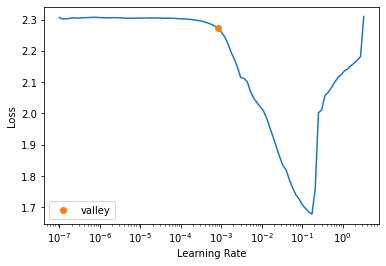

In [12]:
learn = Learner(dls, SimpleCNN(), metrics=[accuracy])
learn.lr_find()

In [13]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.123727,0.114571,0.964095,00:25
1,0.074072,0.082766,0.976952,00:09
2,0.038184,0.056970,0.984667,00:09
3,0.014049,0.042721,0.988571,00:22
4,0.002666,0.043662,0.989714,00:09


In [14]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.001490,0.047290,0.990571,00:08


In [15]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.002454,0.046474,0.990476,00:08


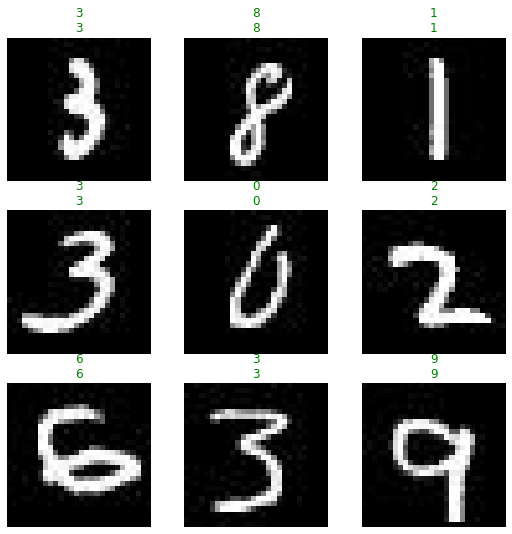

In [16]:
learn.show_results()

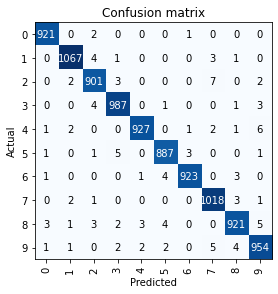

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### My first model from scratch (no help from ChatGPT)

In [60]:
import torch.nn as nn
class MyLinearModel(nn.Module):
    def __init__(self, in_features=28*28*3, out_features=10):
        super(MyLinearModel, self).__init__()
        self.linear = nn.Linear(in_features=in_features, out_features=out_features)
    def forward(self, x):
        x = x.view(-1, 3*28*28)
        x = self.linear(x)
        return x

In [61]:
dls = ImageDataLoaders.from_folder(TRAIN_IMGS, valid_pct=0.25)
print(len(dls.train), len(dls.valid))
xs, ys = dls.train.one_batch()
xs.shape, ys.shape

492 165


(torch.Size([64, 3, 28, 28]), torch.Size([64]))

SuggestedLRs(minimum=0.017378008365631102, steep=0.019054606556892395, valley=0.0010000000474974513)

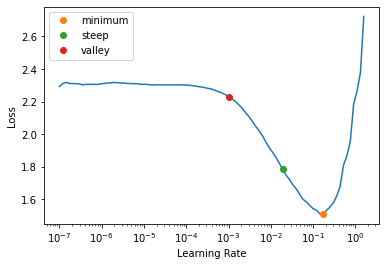

In [62]:
learn = Learner(dls, MyLinearModel(), metrics=[accuracy])
learn.lr_find(suggest_funcs=(steep))

In [51]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.355866,0.324308,0.910667,00:08
1,0.391692,0.403012,0.897714,00:08
2,0.411542,0.414868,0.910381,00:08
3,0.471668,0.487890,0.898095,00:08
4,0.352189,0.407869,0.912000,00:08
5,0.313150,0.387026,0.909524,00:08
6,0.285193,0.364873,0.914190,00:08
7,0.205960,0.333995,0.917429,00:08
8,0.183300,0.323182,0.921905,00:08
9,0.181471,0.319599,0.922286,00:08


In [55]:
next(learn.model.parameters()).device

device(type='cuda', index=0)

### Multi-layered linear model (perceptron :P )

In [76]:
# gpu memory management
import gc, torch
!pip install -Uqq pynvml

def free_gpu():
    gc.collect()
    torch.cuda.empty_cache()
    
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    free_gpu()

In [72]:
import torch.nn as nn

class MultiLinearModel(nn.Module):
    def __init__(self, n_layers=2, in_features=28*28*3, out_features=10, inner_features=256):
        super(MultiLinearModel, self).__init__()
        linear_layers = []
        linear_layers.append(nn.Linear(in_features, inner_features))
        for i in range(n_layers-1):
            linear_layers.append(nn.Linear(inner_features, inner_features))
        linear_layers.append(nn.Linear(inner_features, out_features))
        self.sequential = nn.Sequential(*linear_layers)

    def forward(self, x):
        x = x.view(-1, 3*28*28)
        x = self.sequential(x)
        return x

In [73]:
dls = ImageDataLoaders.from_folder(TRAIN_IMGS, valid_pct=0.25)
print(len(dls.train), len(dls.valid))
xs, ys = dls.train.one_batch()
xs.shape, ys.shape

492 165


(torch.Size([64, 3, 28, 28]), torch.Size([64]))

SuggestedLRs(steep=0.0020892962347716093)

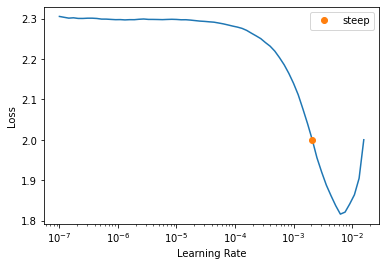

In [83]:
model = MultiLinearModel(n_layers=2,inner_features=256)
learn = Learner(dls, model, metrics=[accuracy])
learn.lr_find(suggest_funcs=(steep))

In [84]:
report_gpu()

GPU:0
process      20688 uses     1191.000 MB GPU memory


In [85]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.343913,0.351107,0.899238,00:09
1,0.343265,0.344895,0.901810,00:08
2,0.344751,0.356513,0.900381,00:09
3,0.320784,0.359403,0.898286,00:09
4,0.284726,0.351374,0.901143,00:09
5,0.260724,0.310684,0.915143,00:09
6,0.233596,0.325295,0.910762,00:09
7,0.233517,0.297955,0.917048,00:09
8,0.199391,0.290101,0.919905,00:09
9,0.185075,0.288211,0.920190,00:09


In [86]:
learn.fit_one_cycle(10, 5*1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.195945,0.301473,0.918381,00:09
1,0.235040,0.315112,0.912286,00:08
2,0.261880,0.315690,0.912476,00:09


KeyboardInterrupt: 

In [87]:
model

MultiLinearModel(
  (sequential): Sequential(
    (0): Linear(in_features=2352, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

## Now let's create the final predictions

In [88]:
test_files = [TEST_IMGS/(str(i)+'.jpg') for i in tqdm(range(len(test_df)))]
len(test_files)

  0%|          | 0/28000 [00:00<?, ?it/s]

28000

In [89]:
test_dl = learn.dls.test_dl(test_files)
preds, _, decoded = learn.get_preds(dl=test_dl, with_decoded=True)

In [90]:
decoded

tensor([2, 0, 9,  ..., 3, 9, 2])

Looks good so far!

## Prepare submission file

In [91]:
submission = pd.read_csv(path/'sample_submission.csv')

In [92]:
submission.shape

(28000, 2)

In [93]:
submission.Label = decoded
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,4
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


## Submit CSV to Kaggle

In [94]:
# write submission csv
technique = 'pytorch multilinear from scratch'
sub_filename = Path('subs')/(COMPETITION_NAME+'-'+technique+'-sub.csv')
submission.to_csv(sub_filename, index=False)

if not iskaggle:
    print('about to submit', sub_filename, 'to kaggle')
    input('continue?')
    ret = kaggle.api.competition_submit(sub_filename, technique, COMPETITION_NAME)
    print(ret)

about to submit subs/digit-recognizer-pytorch multilinear from scratch-sub.csv to kaggle


continue? y


100%|██████████| 208k/208k [00:00<00:00, 462kB/s]


Successfully submitted to Digit Recognizer


## (optional) Save the best model so far

In [96]:
print(COMPETITION_NAME)

digit-recognizer


In [103]:
# learn.export(fname='../../../models/'+(COMPETITION_NAME+'-'+technique)+'.pkl')